In [25]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
#from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import pandas as pd
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
from os import listdir
from os.path import isfile, join
import random
from math import floor
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib import patches

Here I am loading in 100 images that I sampled from random_sample_images and 

In [17]:
images = r'C:\Users\brunolopez\Downloads\komi_model_creation'
annotations = r'C:\Users\brunolopez\Downloads\komi_model_creation'

get the image files and the annotation files as well

In [3]:
img_files = [images + '/' + file for file in listdir(images) if '.jpg' in file] #the image files
ann_files = [annotations + '/' + file for file in listdir(annotations) if '.xml' in file] #the annotation files

We can create a test and training set from the labeled images 

In [46]:
#We will now create a test and training set for these images 
random.seed(2873)
#grab the file names without the jpg or the xml
file_prefixes = [images + '/' + file.split('.jpg')[0] for file in listdir(images) if '.jpg' in file]
#shuffle modifies the original list so we crerate a copy
random.shuffle(file_prefixes)

split = 0.7
split_index = floor(len(file_prefixes) * split)
training = file_prefixes[:split_index]
testing = file_prefixes[split_index:]

Let's create variables to create a our new train and test images/annotations

In [47]:
def create_test_or_trainig_folder(test_or_train, destination_folder):

    path_img = []
    path_ann = []

    for prefix in test_or_train:
        full_path_img = prefix + '.jpg'
        full_path_ann = prefix + '.xml'

        shutil.copy(full_path_img, destination_folder)
        path_img.append(full_path_img)
        path_ann.append(full_path_ann)

    return path_img, path_ann

In [50]:
train_img, train_ann = create_test_or_trainig_folder(training, r'C:\Users\brunolopez\mldata\manga_scrape\komi_train_img' )

C:\Users\brunolopez\Downloads\komi_model_creation/chapter_221_jpg_013
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_47_jpg_013
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_249_jpg_08
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_23_jpg_03
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_184_jpg_014
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_189_jpg_03
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_330_jpg_01
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_178_jpg_011
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_26_jpg_017
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_0_jpg_04
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_326_jpg_05
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_251_jpg_016
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_257_jpg_01
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_17_jpg_07
C:\Users\brunolopez\Downloads\komi

In [51]:
test_img, test_ann = create_test_or_trainig_folder(testing, r'C:\Users\brunolopez\mldata\manga_scrape\komi_test_img' )

C:\Users\brunolopez\Downloads\komi_model_creation/chapter_217_jpg_016
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_201_jpg_015
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_58_jpg_04
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_34_jpg_06
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_268_jpg_018
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_267_jpg_04
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_223_jpg_010
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_340_jpg_13
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_149_jpg_013
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_215_jpg_011
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_305_jpg_03
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_0_jpg_041
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_156_jpg_07
C:\Users\brunolopez\Downloads\komi_model_creation/chapter_202_jpg_013
C:\Users\brunolopez\Downloads\

In [52]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):


    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []
    info_dict['file_name'] = xml_file

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                if subelem.text != None:
                    image_size.append(int(subelem.text))

            #since this is black and white we only have one band at the end
            image_size.append(1)
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(float(subsubelem.text))      

                if subelem.tag == "name":
                    bbox["class"] = subelem.text    
                bbox['img_name'] = xml_file.split('.')[0] + '.jpg' #gets the jpg name

            info_dict['bboxes'].append(bbox)


    final_frame = pd.DataFrame(info_dict['bboxes'])

    return final_frame


def get_all_annotations(ann_files):
    '''
    Iterate through all of the annoation files and create a bounding box 

    '''

    final_frame = pd.DataFrame()

    for file in ann_files:
        ann_info = extract_info_from_xml(file)
        final_frame = pd.concat([final_frame, ann_info], ignore_index = True)

    return final_frame[['img_name', 'xmin', 'ymin','xmax', 'ymax', 'class']]
        

In [53]:
img_test = extract_info_from_xml(train_ann[0])
img_test

,class,img_name,xmin,ymin,xmax,ymax
0,face,C:\Users\brunolopez\Downloads\komi_model_creat...,168,143,234,198
1,face,C:\Users\brunolopez\Downloads\komi_model_creat...,504,149,550,190
2,face,C:\Users\brunolopez\Downloads\komi_model_creat...,610,98,665,146
3,face,C:\Users\brunolopez\Downloads\komi_model_creat...,158,312,462,617
4,face,C:\Users\brunolopez\Downloads\komi_model_creat...,423,313,760,574
5,face,C:\Users\brunolopez\Downloads\komi_model_creat...,391,745,447,803
6,face,C:\Users\brunolopez\Downloads\komi_model_creat...,485,704,572,766
7,face,C:\Users\brunolopez\Downloads\komi_model_creat...,431,907,562,1013


In [54]:
all_frame = get_all_annotations(train_ann)

In [55]:
all_frame.to_csv(r'C:\Users\brunolopez\mldata\manga_scrape\komi_annotation\annotations.txt', header = None, index = None, sep = ' ')

Testing

In [7]:
img = cv2.imread(all_frame['img_name'].iloc[0])

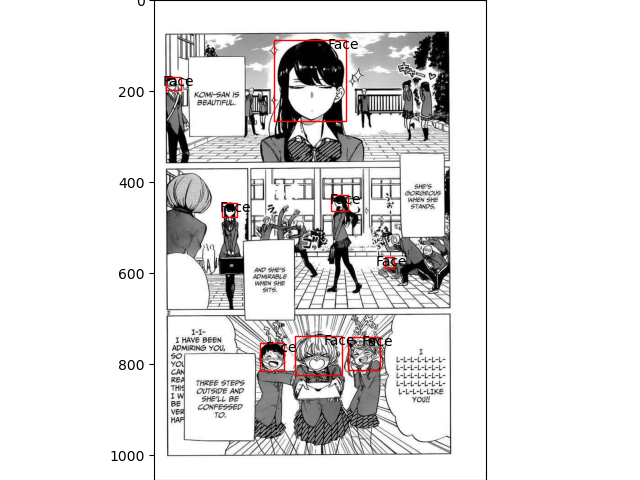

In [15]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

plt.imshow(img)

for index, row in img_test.iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax

    width = xmax - xmin
    height = ymax - ymin

    edgecolor = 'r'
    ax.annotate('Face', xy=(xmax-40,ymin+20))

    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    ax.add_patch(rect)